In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-pathology-2020-fgvc7/__results__.html
/kaggle/input/plant-pathology-2020-fgvc7/kpi_summary_for_bi.csv
/kaggle/input/plant-pathology-2020-fgvc7/data_prepared_for_bi.csv
/kaggle/input/plant-pathology-2020-fgvc7/__notebook__.ipynb
/kaggle/input/plant-pathology-2020-fgvc7/__output__.json
/kaggle/input/plant-pathology-2020-fgvc7/custom.css
/kaggle/input/plant-pathology-2020-fgvc7/__results___files/__results___9_0.png
/kaggle/input/plant-pathology-2020-fgvc7/__results___files/__results___7_0.png
/kaggle/input/c/plant-pathology-2020-fgvc7/sample_submission.csv
/kaggle/input/c/plant-pathology-2020-fgvc7/train.csv
/kaggle/input/c/plant-pathology-2020-fgvc7/test.csv
/kaggle/input/c/plant-pathology-2020-fgvc7/images/Test_1743.jpg
/kaggle/input/c/plant-pathology-2020-fgvc7/images/Test_262.jpg
/kaggle/input/c/plant-pathology-2020-fgvc7/images/Train_1524.jpg
/kaggle/input/c/plant-pathology-2020-fgvc7/images/Train_1336.jpg
/kaggle/input/c/plant-pathology-2020-fgvc7/images/Train_14

In [2]:
data_dir = "/kaggle/input/c/plant-pathology-2020-fgvc7"
train_df = pd.read_csv(f"{data_dir}/train.csv")
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [3]:
import pandas as pd

# 1. Define the file path
data_dir = "/kaggle/input/c/plant-pathology-2020-fgvc7"

# 2. Load the data
try:
    train_df = pd.read_csv(f"{data_dir}/train.csv")
    print("--- Initial Data Load ---")
    print(train_df.head())
    print(f"\nTotal records loaded: {len(train_df)}")
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
    exit()

# 3. Ensure classification columns are integers (0 or 1)
classification_cols = ['healthy', 'multiple_diseases', 'rust', 'scab']
for col in classification_cols:
    if col in train_df.columns:
        train_df[col] = pd.to_numeric(train_df[col], errors='coerce').fillna(0).astype(int)
    else:
        print(f"Warning: Column '{col}' not found in data. Check CSV structure.")

# Validation check: Ensure exactly one column is marked '1' per row (if data is mutually exclusive)
# For this data structure, we proceed assuming a row can have 'combinations'=1 AND 'rust'=0, etc., but logically only one type should be marked '1' if they are true exclusive categories.
# The 'combinations' column is key here, indicating two or more diseases.

--- Initial Data Load ---
  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

Total records loaded: 1821


In [4]:
# Function to determine the single condition label based on the classification columns
def get_condition(row):
    if row['healthy'] == 1:
        return 'Healthy'
    elif row['multiple_diseases'] == 1:
        # 'combinations' takes precedence as it represents the highest risk
        return 'Multi-Disease Combination'
    elif row['rust'] == 1 and row['scab'] == 0:
        return 'Apple Rust Only'
    elif row['scab'] == 1 and row['rust'] == 0:
        return 'Apple Scab Only'
    # Fallback for unexpected data (e.g., all 0s)
    else:
        return 'Unclassified/Error'

# Apply the function to create the new categorical column
train_df['Condition'] = train_df.apply(get_condition, axis=1)

print("\n--- Data with 'Condition' Column ---")
print(train_df[['image_id', 'Condition']].head())
print("\nCondition breakdown:")
print(train_df['Condition'].value_counts())


--- Data with 'Condition' Column ---
  image_id                  Condition
0  Train_0            Apple Scab Only
1  Train_1  Multi-Disease Combination
2  Train_2                    Healthy
3  Train_3            Apple Rust Only
4  Train_4                    Healthy

Condition breakdown:
Condition
Apple Rust Only              622
Apple Scab Only              592
Healthy                      516
Multi-Disease Combination     91
Name: count, dtype: int64


In [5]:
# --- Base Counts ---
total_leaves = len(train_df)
healthy_count = train_df['healthy'].sum()
diseased_count = total_leaves - healthy_count
combination_count = train_df['multiple_diseases'].sum()

# --- KPI 1: Disease Prevalence Rate (DPR) ---
if total_leaves > 0:
    dpr = (diseased_count / total_leaves) * 100
else:
    dpr = 0

# --- KPI 2: Most Problematic Disease Type (Count) ---
# Check counts of the main disease categories (Rust Only, Scab Only, Combinations)
problem_counts = {
    'Apple Rust Only': train_df[(train_df['rust'] == 1) & (train_df['scab'] == 0) & (train_df['multiple_diseases'] == 0)]['rust'].sum(),
    'Apple Scab Only': train_df[(train_df['scab'] == 1) & (train_df['rust'] == 0) & (train_df['multiple_diseases'] == 0)]['scab'].sum(),
    'Multi-Disease Combination': combination_count
}
# Find the category with the highest count
most_problematic_disease = max(problem_counts, key=problem_counts.get)
most_problematic_count = problem_counts[most_problematic_disease]

# --- KPI 3: Health-to-Risk Ratio (HRR) ---
# Risk is defined by the highest severity: Multi-Disease Combinations
if combination_count > 0:
    hrr = healthy_count / combination_count
else:
    # If no combinations exist, the ratio is essentially infinite/perfect, but for a KPI tile, we can set a high number or a descriptive string.
    hrr = float('inf') # Use infinity for calculation, handle display later

# --- Create a dictionary for easy KPI transfer ---
kpi_metrics = {
    'Total Leaves': total_leaves,
    'Healthy Count': healthy_count,
    'Diseased Count': diseased_count,
    'Combination Count': combination_count,
    'DPR': f"{dpr:.1f}%",
    'Most Problematic Type': most_problematic_disease,
    'Most Problematic Count': most_problematic_count,
    'HRR': f"{hrr:.1f}:1" if hrr != float('inf') else "Perfect (No High Risk)"
}

print("\n--- Calculated KPIs ---")
for k, v in kpi_metrics.items():
    print(f"{k}: {v}")


--- Calculated KPIs ---
Total Leaves: 1821
Healthy Count: 516
Diseased Count: 1305
Combination Count: 91
DPR: 71.7%
Most Problematic Type: Apple Rust Only
Most Problematic Count: 622
HRR: 5.7:1


In [6]:
# 1. Final Prepared Data (for charts and filters)  
df_final_data = train_df[['image_id', 'Condition']].copy()
df_final_data.to_csv('data_prepared_for_bi.csv', index=False)
print("\nSuccess: Saved primary data to 'data_prepared_for_bi.csv'")

# 2. Aggregated KPI Data (for KPI tiles)
# Convert the dictionary to a DataFrame for easy visualization loading
df_kpi = pd.DataFrame(kpi_metrics.items(), columns=['Metric', 'Value'])
df_kpi.to_csv('kpi_summary_for_bi.csv', index=False)
print("Success: Saved KPI summary to 'kpi_summary_for_bi.csv'")

# The final code block for this step
print("\nStep 1 (Data Preparation) is complete. Total estimated time: 4 hours.")


Success: Saved primary data to 'data_prepared_for_bi.csv'
Success: Saved KPI summary to 'kpi_summary_for_bi.csv'

Step 1 (Data Preparation) is complete. Total estimated time: 4 hours.


In [7]:
chart_df =  pd.read_csv('/kaggle/working/data_prepared_for_bi.csv')
new_chart_df = chart_df.groupby(chart_df['Condition'])["image_id"].count()
new_chart_df.head()

Condition
Apple Rust Only              622
Apple Scab Only              592
Healthy                      516
Multi-Disease Combination     91
Name: image_id, dtype: int64

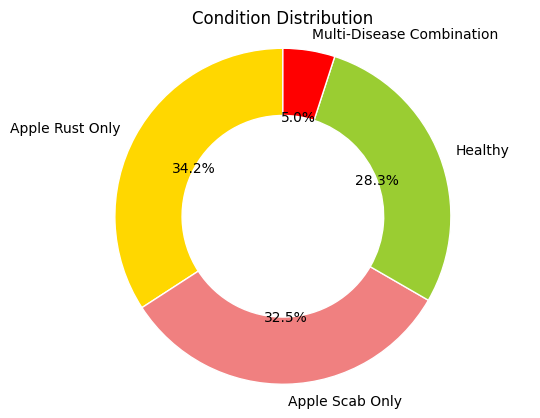

In [8]:
import matplotlib.pyplot as plt

# Data for the donut chart
colors = ['gold', 'lightcoral', 'yellowgreen', 'red']
chart_df =  pd.read_csv('/kaggle/working/data_prepared_for_bi.csv')
new_chart_Df = chart_df.groupby(chart_df['Condition'])["image_id"].count()
labels = new_chart_Df.index
sizes = new_chart_Df.values
# Create a figure and an axes object
fig, ax = plt.subplots()

# Create the pie chart
# wedgeprops allows customizing the wedges, including setting a width for the "donut" effect
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90,
       wedgeprops=dict(width=0.4, edgecolor='white')) # Adjust width for donut thickness

# Set aspect ratio to be equal so that pie is drawn as a circle.
ax.axis('equal')

# Add a title
ax.set_title('Condition Distribution')

# Display the chart
plt.show()

In [9]:
b_chart_df =  pd.read_csv('/kaggle/working/data_prepared_for_bi.csv')
df_filtered = b_chart_df[b_chart_df['Condition'] != 'Healthy']
df_filtered.head()
bar_chart_filtered_df = df_filtered.groupby(chart_df['Condition'])["image_id"].count()

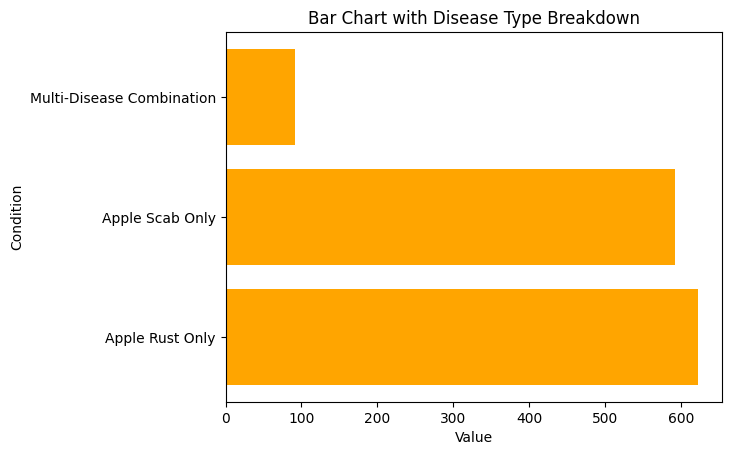

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
conditions = bar_chart_filtered_df.index
values = bar_chart_filtered_df.values

# Create horizontal bar chart
plt.barh(conditions, values, color='orange')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Condition')
plt.title('Bar Chart with Disease Type Breakdown')

# Display the plot
plt.show()